# Learning Outcomes
1. How to measure and quantify the image segmentation pipeline performance? One of the metric is called Intersection over Union (IoU)
2. Edge detection (concepts image gradient and direction), it involves convolution, kernel
    - Sobel x and y
    - Scharr (first order derivatives)
    - Laplacian (second order derivatives)
    - Canny edge detector
3. Contour detection `cv.findContour()`. Input for this function usually has to be thresholded/ edge detection output.
4. Contour features
    - area
    - perimeter
    - centroid
    - bounding box
5. Contour properties: elpful for object recognition
    - aspect ratio
    - circularity (detecting circular object, this is gonna be helpful for the activity)
6. Blob detection (built-in function in OpenCV). Very flexible and powerful.


## IoU

$$IoU = \frac{|A \cap B|}{|A \cap B|}

In [1]:
# setup
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

In [2]:
def computeIOU(boxA, boxB):
    '''The format of boxA and boxB is xyxy'''
    # compute intersection area
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    # to make sure we never get negative
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    # area of boxA and boxB
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [3]:
img = cv.imread('images/lena.jfif')

In [4]:
boxes = cv.selectROIs('bounding boxes', img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

In [5]:
boxes #xywh

array([[ 93,  75,  69, 100],
       [ 82,  51,  83, 128]])

In [6]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[0] + box[2], box[1] + box[3]]

In [7]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 2)
cv.rectangle(img_copy, (pred[0], pred[1]), (pred[2], pred[3]), (255, 0, 0), 1)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25),
          cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

show_img("IOU", img_copy)

The minimum threshold for IoU should be 0.55 for an image to be considered as segmented correctly. This is for Project A.

## Image gradients (Edge detection)
Convolutions -> derivatives -> gradients -> edge. SObel x and y. Kernel:
<br><br>
Sobel x:
$$\begin{bmatrix} -1 & 0 & 1 \\ - 2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

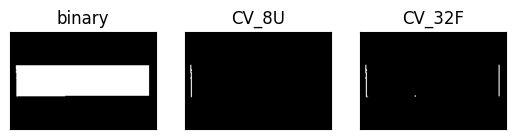

In [8]:
# caveat / pitfall
img = cv.imread('images/wood_planck.jfif', 0)

# threshold
th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

# edge detection (wrong)
sobelx_8u = cv.Sobel(th, cv.CV_8U, 1, 0, ksize = -1) 

# Right way
sobely_32f = cv.Sobel(th, cv.CV_32F, 1, 0, ksize = -1)

# exchange the 0 and 1 (vertical -> horizontal edge map)
sobelx = cv.convertScaleAbs(sobely_32f)

plt.subplot(131), plt_img(th, 'binary')
plt.subplot(132), plt_img(sobelx_8u, "CV_8U")
plt.subplot(133), plt_img(sobelx, "CV_32F")
plt.show()

## Laplacian


In [9]:
img = cv.imread('images/lena.jfif', 0)

# blur -> laplacian (LoG)
blur = cv.GaussianBlur(img, (5, 5), 0)
laplacian_img = cv.Laplacian(blur, cv.CV_16S)
laplacian_img = cv.convertScaleAbs(laplacian_img)

img_combined = np.hstack((img, laplacian_img))
show_img('LoG', img_combined)

## Construct gradient map

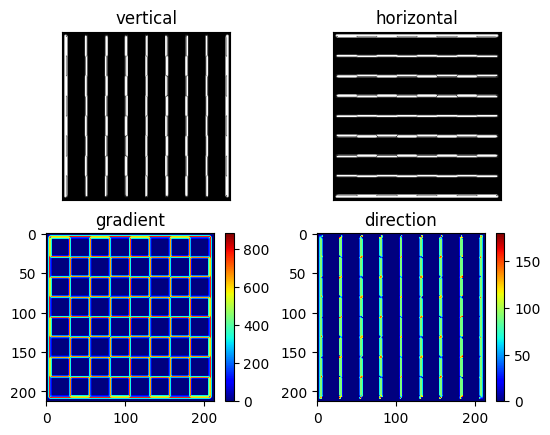

In [10]:
img = cv.imread("images/chessboard.png", 0)

# apply sobel x and sobel y
sobelx = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely_8u = cv.convertScaleAbs(sobely)

# gradient
gradient = cv.magnitude(sobelx, sobely)
# direction
direction = np.arctan2(sobelx, sobely) * 180 / np.pi % 180

plt.subplot(221), plt_img(sobelx_8u, "vertical")
plt.subplot(222), plt_img(sobely_8u, "horizontal")
plt.subplot(223), plt.imshow(gradient, cmap="jet"), plt.title("gradient"), plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap="jet"), plt.title("direction"), plt.colorbar()

plt.show()

## Canny edge detector
- enhance accuracy by reducing false positives
- flexible

1. Gaussian blurring

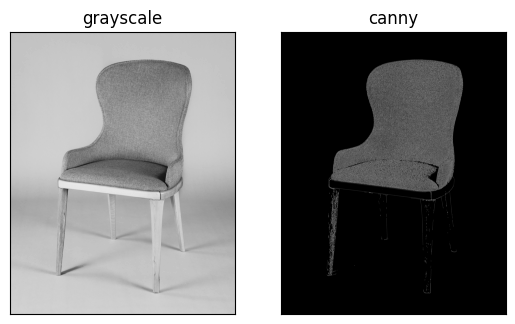

In [11]:
img = cv.imread("images/chair.jpg", 0)
edge =cv.Canny(img, 100, 300) # 50->100, 2->5 for ratio, in this case, 3

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

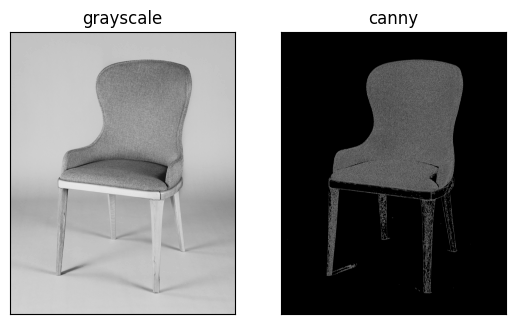

In [12]:
img = cv.imread("images/chair.jpg", 0)
edge =cv.Canny(img, 30, 150) 

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

The key takeaway is that the determination of appropriate Th1 and Th2 is crucial for the success of edge detection.

### create trackbar to tune the hysterisis threshold

In [15]:
img = cv.imread('images/lena.jfif')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

wn = 'Canny edge'
trackbar_name = 'Th1'
ksize = 3
ratio = 3.5

def cannyThreshold(val):
    edge = cv.Canny(gray, val, ratio*val, apertureSize=ksize)
    # create mask
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbar_name, wn, 10, 100, cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

## Automatic canny edge detector

In [38]:
def auto_canny(img, method, sigma=0.33):
    """"Args:
    img: source grayscale image
    method: median, otsu and triangle
    sigma: 0.33 (default)"""
    if method == 'median':
        Th = np.median(img)
        
    elif method == 'triangle':
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    elif method == 'otsu':
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    else:
        raise Exception('Method specified unavailable')
    
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img, lowTh, highTh)

## Contour 
curves join the boundaries that separate regions of different texture and brightness (blobs). 
1. Read image
2. Threshold / edge detection
3. `cv.findContour()`

In [17]:
rect = np.zeros((256, 256), dtype=np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

show_img('rect', rect)

In [22]:
# _ => Hierachy, not important here
contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(type(contours))
len(contours)

<class 'tuple'>


1

In [24]:
contours[0] # contour is actually coordinates of points

array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32)

In [25]:
img_bgr = cv.cvtColor(rect, cv.COLOR_GRAY2BGR)

cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)

show_img('contour', img_bgr)

In [28]:
img = cv.imread('images/monitor.jfif')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Threshold
th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# find contour
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# draw contour
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 2)

show_img('contour', img_copy)

## Contour features
- perimeter
- area
- centroid (center of mass)
- bounding box

In [29]:
cnt = contours[0]

In [31]:
M = cv.moments(cnt) # pay attention to m00, m10 and m01
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [32]:
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

print(f'the centroid of monitor: {(cx, cy)}')

the centroid of monitor: (105, 103)


In [34]:
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)

print(f"The area of contour: {area}")
print(f"The perimeter of contour: {peri:.3f}")

The area of contour: 37113.5
The perimeter of contour: 1056.777


## Contour properties

aspect ratio: 
$$aspect \ ratio = \frac
aspect ratio = (width) / (height)

circularity:
circularity = (4 * pi * Area) / (Perimeter)^2

In [36]:
img = cv.imread('images/remote-controller.webp')

show_img('img', img)

In [39]:
# resizing -> grayscale -> bilateral filtering -> edge detection -> contour ->
# contour features

factor = 300 / img.shape[1] # scale factor = output width / image width
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method='triangle')

show_img('edge', edge)

In [42]:
# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# sort contour with regard to area in descending order and take first five
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
screen = None

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        screen = c
        break
        
img_copy = img.copy()
cv.drawContours(img_copy, [screen], -1, (0, 255, 0), 2)

show_img('screen', img_copy)

## Demo of Color-based Segmentation on Webcams

In [45]:
# segment red object
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

# segment 
cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit('webcam not detected')
    
# parameter initialization
fixed_width = min_area = 500 # make sure the segmented object is not small in size
# dont want to segment small objects
factor = fixed_width / cap.get(3) # frame width
kernel = np.ones((3, 3), dtype=np.uint8)

while True:
    ret, frame = cap.read()
    
    if not ret:
        print('No frame received!')
        break
        
    # resize -> blur -> hsv -> inRange -> mask integration -> morphological -> 
    # contours -> bounding box
    
    resized = cv.resize(frame, None,fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)
    
    # find contour
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    bbs = []
    
    for c in contours:
        area = cv.contourArea()
        if area > min_area:
            bb = cv.boundingRect(c)
            bbs.append(bb)
            
    for bb in bbs:
        x, y, w, h == bb
        cv.rectangle(resized, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    cv.imshow('red object', resized)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break

cv.destroyAllWindows()    
cap.release()

No frame received!


# Activity

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Question 1
1. Experiment with different edge detectors: Sobel, Laplacian, Prewitt, Scharr derivatives and Canny operators (all with aperture size of 3) on image named 'pineapple.jfif'. Comment on the results.

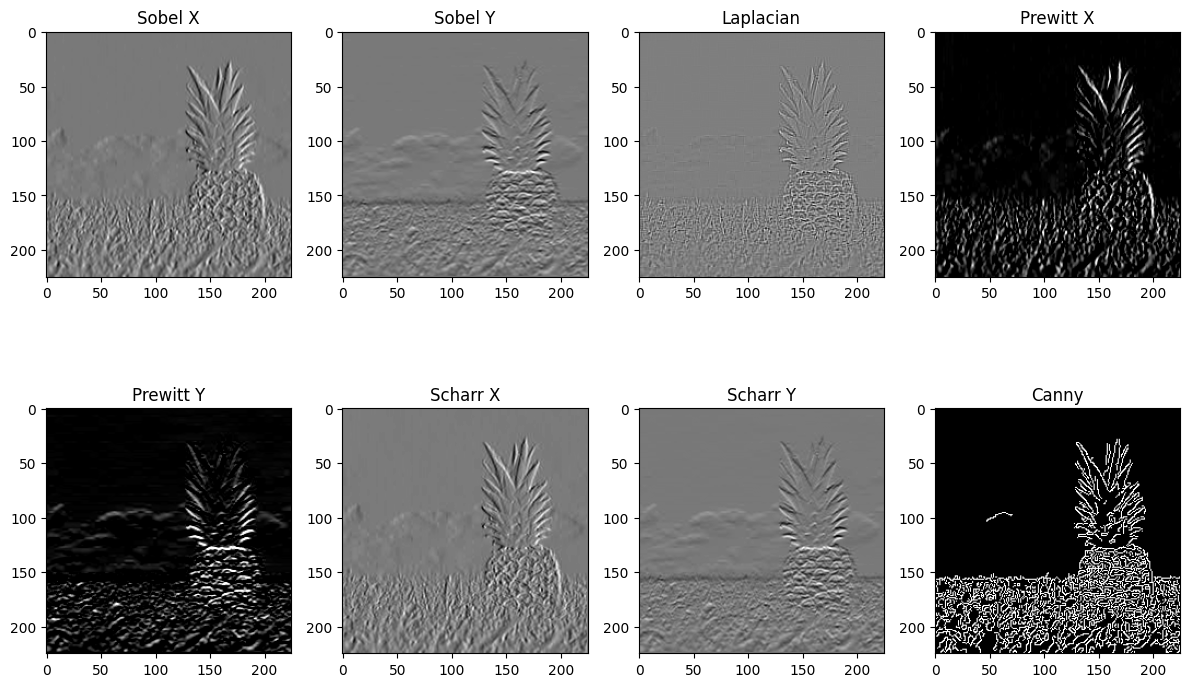

In [12]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load the input image
image = cv.imread('images/pineapple.jfif')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply different edge detectors
sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
laplacian = cv.Laplacian(gray, cv.CV_64F, ksize=3)
prewitt_x = cv.filter2D(gray, -1, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
prewitt_y = cv.filter2D(gray, -1,  np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
scharr_x = cv.Scharr(gray, cv.CV_64F, 1, 0)
scharr_y = cv.Scharr(gray, cv.CV_64F, 0, 1)
canny = cv.Canny(gray, threshold1=100, threshold2=200)

# Display the results using matplotlib
plt.figure(figsize=(12, 8))

# plt.subplot(2, 4, x)
# plt.imshow(image, cmap='gray')
# plt.title('Original')

plt.subplot(2, 4, 1)
plt.imshow(sobel_x, cmap='gray')
plt.title('Sobel X')

plt.subplot(2, 4, 2)
plt.imshow(sobel_y, cmap='gray')
plt.title('Sobel Y')

plt.subplot(2, 4, 3)
plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian')

plt.subplot(2, 4, 4)
plt.imshow(prewitt_x, cmap='gray')
plt.title('Prewitt X')

plt.subplot(2, 4, 5)
plt.imshow(prewitt_y, cmap='gray')
plt.title('Prewitt Y')

plt.subplot(2, 4, 6)
plt.imshow(scharr_x, cmap='gray')
plt.title('Scharr X')

plt.subplot(2, 4, 7)
plt.imshow(scharr_y, cmap='gray')
plt.title('Scharr Y')

plt.subplot(2, 4, 8)
plt.imshow(canny, cmap='gray')
plt.title('Canny')

plt.tight_layout()
plt.show()

### _Comments on Q1_
1. Sobel X and Sobel Y provide edges in the horizontal and vertical directions, respectively.
2. Laplacian highlights edges in all directions and emphasizes high-frequency changes.
3. Prewitt X and Prewitt Y offer similar results to Sobel but with slightly different filter kernels.
4. Scharr X and Scharr Y provide more accurate edge detection compared to Sobel, especially for diagonal edges.
5. Canny detects edges with well-defined and single-pixel widths, and canny edges are stronger and more isolated compared to other methods.

## Question 2
2. Write a program to identify the white object (probably laptop) present in the image 'electronic.jfif'. Draw bounding boxes on the objects.

In [14]:
# Load the input image
image = cv.imread('images/electronic.jfif')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply thresholding to segment white objects
_, thresholded = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)

# Find contours of white objects
contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around white objects
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes
cv.imshow('Identified Objects', image)

# Wait for a key event and close the window
cv.waitKey(0)
cv.destroyAllWindows()

## Question 3
3. Isolate the clock with the aid of edge detection and contours' properties. The example result should be as follows: 
[clock_segmented.jpg](attachment:clock_segmented.jpg)

In [19]:
import cv2 as cv

# Load the segmented image
image = cv.imread('images/clock.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv.Canny(gray, threshold1=30, threshold2=100)

# Find contours of the edges
contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assumed to be the clock)
largest_contour = max(contours, key=cv.contourArea)

# Create a mask for the clock
mask = cv.drawContours(image.copy(), [largest_contour], 0, (255, 255, 255), -1)

# Apply the mask to the original image
clock_isolated = cv.bitwise_and(image, mask)

# Display the isolated clock
cv.imshow('Isolated Clock', clock_isolated)

# Wait for a key event and close the window
cv.waitKey(0)
cv.destroyAllWindows()